In [ ]:
import os

## For Google Colab: Manually set environment variables for AWS credentials
# os.environ["AWS_ACCESS_KEY_ID"] = "PASTE_YOUR_KEY_HERE"
# os.environ["AWS_SECRET_ACCESS_KEY"] = "PASTE_YOUR_SECRET_HERE"
# os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

from dotenv import load_dotenv
load_dotenv()

In [ ]:
import polars as pl

country_code = 'UA'  # Example country code for Ukraine

institution_country_code_df = pl.scan_parquet("s3://openalex-bulk/institutions/country_code_00.parquet.zstd")
local_institutions_df = institution_country_code_df.explode("country_code").filter(
    country_code = country_code
)

author_institution_df = pl.scan_parquet("s3://openalex-bulk/authors/affiliations_institution_id_00.parquet.parquet.zstd")

local_researchers_df = author_institution_df.explode("affiliations_institution_id").join(
    local_institutions_df,
    left_on="affiliations_institution_id",
    right_on="institution_id",
    how="inner"
)

local_researchers = local_researchers_df.unique("author_id").collect().get_column("author_id").to_numpy()

In [2]:
len(local_researchers), local_researchers[:10]

(379687,
 array(['A5095310827', 'A5096313071', 'A5025181817', 'A5095573162',
        'A5098936845', 'A5093912031', 'A5095404538', 'A5063352517',
        'A5107299296', 'A5027403504'], dtype=object))

In [ ]:
is_oa_df = pl.scan_parquet("s3://openalex-bulk/works/is_oa/*",)

publication_year_df = pl.scan_parquet("s3://openalex-bulk/works/publication_year/*")\
.filter(
    pl.col("publication_year")>2018,
    pl.col("publication_year")<2022,
)

author_works_df = pl.scan_parquet(
    "s3://openalex-bulk/works/author_works/*",
    storage_options={"region": "us-west-2"}
).with_columns(
    pl.col("work_id").list.len().alias("works_count")
)

# local_works_df = author_ids_df.join(local_researchers_df.lazy(), on="author_id", how="semi")


In [4]:
publication_year_df.describe()

statistic,work_id,publication_year
str,str,f64
"""count""","""31301819""",3.1301819e7
"""null_count""","""0""",0.0
"""mean""",null,2019.983774
"""std""",null,0.803985
"""min""","""W1000129717""",2019.0
"""25%""",null,2019.0
"""50%""",null,2020.0
"""75%""",null,2021.0
"""max""","""W999971504""",2021.0


In [5]:
publication_year_df.select(
    pl.col("publication_year").alias("year"),
    pl.count("work_id").over("publication_year").alias("work_count")
).unique(["year", "work_count"]).collect()

year,work_count
i64,u32
2021,9866792
2019,10374698
2020,11060329


In [ ]:
local_works_lf = author_works_df.filter(
    pl.col("author_id").is_in(local_researchers),
    pl.col("works_count") < 100,
    pl.col("works_count") > 3
).explode("work_id").join(
    is_oa_df,
    left_on="work_id",
    right_on="work_id",
    how="left"
).join(
    publication_year_df,
    left_on="work_id",
    right_on="work_id",
    how="inner"
)

In [7]:
# local_works_lf = author_works_df.join(
#     local_researchers_df,
#     left_on="author_id",
#     right_on="author_id",
#     how="semi"
# ).filter(
#     pl.col("works_count") < 100,
#     # pl.col("works_count") > 3
# ).explode("work_id").join(
#     is_oa_df,
#     left_on="work_id",
#     right_on="work_id",
#     how="left"
# ).join(
#     publication_year_df,
#     left_on="work_id",
#     right_on="work_id",
#     how="inner"
# )

In [8]:
# author_works_df.head(30).explode("work_id").join(
#     publication_year_df,
#     left_on="work_id",
#     right_on="work_id",
#     how="inner"
# ).collect().sort("publication_year")

In [9]:
local_works_df = local_works_lf.collect()
# print(local_works_df.estimated_size())

In [10]:
local_works_df.head(), local_works_df.height, local_works_df.select("publication_year").max()

(shape: (5, 5)
 ┌─────────────┬─────────────┬─────────────┬───────┬──────────────────┐
 │ author_id   ┆ work_id     ┆ works_count ┆ is_oa ┆ publication_year │
 │ ---         ┆ ---         ┆ ---         ┆ ---   ┆ ---              │
 │ str         ┆ str         ┆ u32         ┆ bool  ┆ i64              │
 ╞═════════════╪═════════════╪═════════════╪═══════╪══════════════════╡
 │ A5109356243 ┆ W2908721879 ┆ 60          ┆ null  ┆ 2019             │
 │ A5070812440 ┆ W2908721879 ┆ 44          ┆ null  ┆ 2019             │
 │ A5077421283 ┆ W2911348583 ┆ 68          ┆ null  ┆ 2019             │
 │ A5056002524 ┆ W2913880318 ┆ 7           ┆ null  ┆ 2019             │
 │ A5065686221 ┆ W2913880318 ┆ 72          ┆ null  ┆ 2019             │
 └─────────────┴─────────────┴─────────────┴───────┴──────────────────┘,
 684932,
 shape: (1, 1)
 ┌──────────────────┐
 │ publication_year │
 │ ---              │
 │ i64              │
 ╞══════════════════╡
 │ 2021             │
 └──────────────────┘)

In [11]:
import numpy as np

local_works_df = local_works_df.with_columns(
    pl.when(local_works_df["is_oa"].is_null())
    .then(
        pl.Series(
            [np.random.choice([True, False]) if is_null else None for is_null in local_works_df["is_oa"].is_null()]
        )
    )
    .otherwise(pl.col("is_oa"))
    .alias("is_oa")
)
local_works_df

author_id,work_id,works_count,is_oa,publication_year
str,str,u32,bool,i64
"""A5109356243""","""W2908721879""",60,true,2019
"""A5070812440""","""W2908721879""",44,true,2019
"""A5077421283""","""W2911348583""",68,true,2019
"""A5056002524""","""W2913880318""",7,false,2019
"""A5065686221""","""W2913880318""",72,true,2019
…,…,…,…,…
"""A5029153106""","""W3216473697""",19,false,2019
"""A5079241820""","""W3216473697""",44,true,2019
"""A5021627730""","""W3216473697""",25,false,2019


In [12]:
# local_works_df.group_by(["is_oa", "publication_year"]).agg(
#     pl.col("work_id")
# )

In [19]:
yearly_pub_oa = local_works_df.select(
    pl.col("publication_year"),
    pl.col("is_oa"),
    pl.count("work_id").over(["publication_year", "is_oa"]).alias("work_count"),
).unique(["publication_year", "is_oa"]).pivot(
    index="publication_year",
    on="is_oa",
    values="work_count"
).with_columns(
    (pl.col("true") / ( pl.col("true") + pl.col("false") )).alias("oa_adaption")
).sort("publication_year")

In [20]:
yearly_pub_oa

publication_year,true,false,oa_adaption
i64,u32,u32,f64
2019,104164,106797,0.49376
2020,120736,120766,0.499938
2021,116381,116088,0.50063


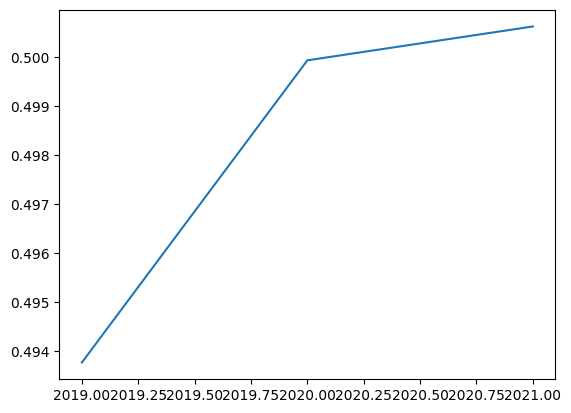

In [ ]:
import matplotlib.pyplot as plt
plt.plot(yearly_pub_oa["publication_year"], yearly_pub_oa["oa_adaption"])